<a href="https://colab.research.google.com/github/vincent-grari/DIVERS/blob/main/toyscenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install geojsoncontour

In [2]:
!git clone https://github.com/diana-hep/carl.git

Cloning into 'carl'...
remote: Enumerating objects: 1974, done.
remote: Total 1974 (delta 0), reused 0 (delta 0), pack-reused 1974
Receiving objects: 100% (1974/1974), 6.98 MiB | 7.90 MiB/s, done.
Resolving deltas: 100% (1228/1228), done.


In [5]:
%cd

/root


In [7]:
%cd carl
!python3 setup.py install
%cd

[Errno 2] No such file or directory: 'carl !python3 setup.py install %cd'
/root


In [10]:
!pip3 install theano

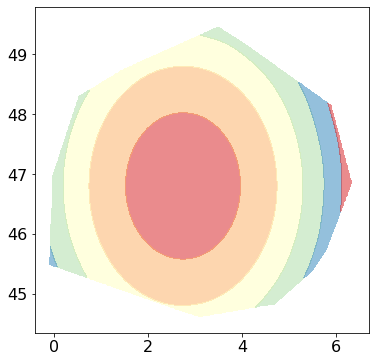

In [23]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
import sys
import numpy.random as npr
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0

import numpy as np
from numpy.testing import assert_array_equal

#from carl.carl.distributions import Mixture, MultivariateNormal, Uniform, Normal
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.mlab import griddata

np.random.seed(1)


# Setup
temp_mean = 12
temp_std  = 2
debug     = False

# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)
n_samples = 2000
# Create a dataframe with fake data
df = pd.DataFrame({
    'longitude':   np.random.normal(2.75,     1.,     n_samples),
    'latitude':    np.random.normal(46.8,     0.8,     n_samples),
    })

df['salaire'] = ((df['latitude']-46.8)**2 + (df['longitude']-2.75)**2)*1000+1000
df['temperature']= (df['latitude']-46.8) *20+20

import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
p0 = multivariate_normal(np.array([0., 0.]),np.array([[1., -0.5], [-0.5, 1.]]))
p1 = multivariate_normal(np.array([1., 1.]),np.eye(2))
ps = norm(0.0, 1.0)

X0 = p0.rvs(n_samples // 2, random_state = 1)
X1 = p1.rvs(n_samples // 2, random_state = 1)
s = ps.rvs(n_samples, random_state = 1).ravel()
X1[:, 1] += 3*np.sin(s[n_samples // 2:])

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1


# The original data
x_orig = np.asarray(df.longitude.tolist())
y_orig = np.asarray(df.latitude.tolist())
z_orig = np.asarray(df.salaire.tolist())

# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='cubic')

# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)

# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)

# Set up the folium plot
geomap = folium.Map([df.latitude.mean(), df.longitude.mean()], zoom_start=10, tiles="cartodbpositron")

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)

# Add the colormap to the folium map
cm.caption = 'Temperature'
geomap.add_child(cm)

# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)

# Plot the data
geomap.save(f'folium_contour_temperature_map.html')

In [108]:
df['temperature']

0        1768.427316
1        1965.561979
2        1043.088238
3        1521.226565
4        2911.898428
            ...     
1995     1684.453889
1996     1511.289788
1997     7280.875566
1998    12980.835112
1999     2552.727176
Name: temperature, Length: 2000, dtype: float64

In [106]:
.mean()

2543.9966258507584